In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
# plt.style.use("ggplot")
sns.set_style("darkgrid")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
data = pd.read_csv("final_without_weather.csv")
data.drop(['Month'], axis =1, inplace= True)
data.set_index("pickuptime", inplace= True)
num_pickups = data.total
num_green_pickups = data.green
num_yellow_pickups = data.yellow
data.drop(['green', 'yellow', 'total'], axis =1, inplace = True)

In [3]:
def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace = True)
        
    return agg

Time sequence 24hours(from 23 hours get 1 hours)

In [4]:
features_and_target = pd.concat([data, num_pickups], axis = 1)
values = features_and_target.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

n_hours = 23

reframed = series_to_supervised(scaled, n_hours, 1)

n_features = features_and_target.shape[1]


In [5]:
# delete significantly wrong data
total_values = reframed.values
n_p = np.argmin(total_values[365*24*3:, -1])
n_p = n_p + 365*24*3

a = total_values[: n_p, :]
b = total_values[n_p + n_hours + 1 : , :]
values = np.concatenate((a, b), axis=0)

In [6]:
# split into train and test sets# split i # split  
n_train_hours = 365 * 24 * 3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 115) 26280 (26280,)
(26280, 23, 5) (26280,) (6517, 23, 5) (6517,)


In [7]:
# design network
model = Sequential()
model.add(LSTM(24, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 26280 samples, validate on 6517 samples
Epoch 1/100
 - 6s - loss: 0.0906 - val_loss: 0.0502
Epoch 2/100
 - 5s - loss: 0.0591 - val_loss: 0.0372
Epoch 3/100
 - 5s - loss: 0.0437 - val_loss: 0.0333
Epoch 4/100
 - 5s - loss: 0.0369 - val_loss: 0.0278
Epoch 5/100
 - 5s - loss: 0.0327 - val_loss: 0.0268
Epoch 6/100
 - 5s - loss: 0.0295 - val_loss: 0.0256
Epoch 7/100
 - 5s - loss: 0.0272 - val_loss: 0.0236
Epoch 8/100
 - 5s - loss: 0.0256 - val_loss: 0.0227
Epoch 9/100
 - 5s - loss: 0.0248 - val_loss: 0.0205
Epoch 10/100
 - 5s - loss: 0.0242 - val_loss: 0.0195
Epoch 11/100
 - 5s - loss: 0.0235 - val_loss: 0.0180
Epoch 12/100
 - 5s - loss: 0.0229 - val_loss: 0.0178
Epoch 13/100
 - 5s - loss: 0.0223 - val_loss: 0.0175
Epoch 14/100
 - 5s - loss: 0.0220 - val_loss: 0.0176
Epoch 15/100
 - 5s - loss: 0.0215 - val_loss: 0.0178
Epoch 16/100
 - 5s - loss: 0.0212 - val_loss: 0.0174
Epoch 17/100
 - 5s - loss: 0.0211 - val_loss: 0.0177
Epoch 18/100
 - 5s - loss: 0.0208 - val_loss: 0.0179
Epoch 

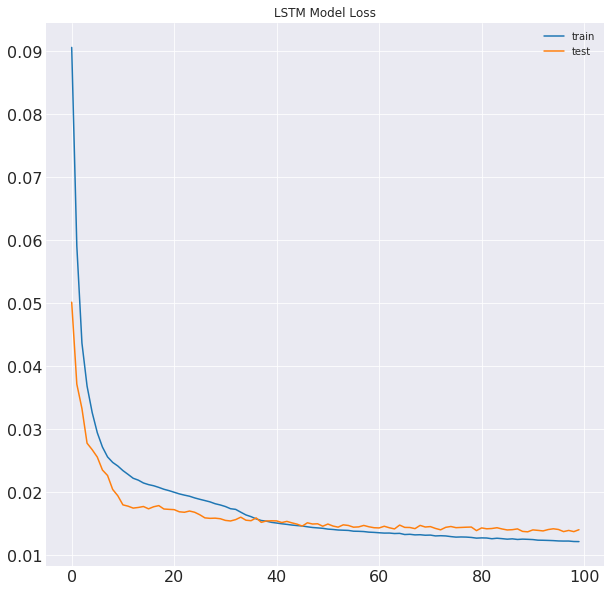

In [8]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [9]:
# make a prediction 
yhat = model.predict(test_X)
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

# invert scaling for forecast# invert 
inv_yhat = np.concatenate((test[:, 115:119], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 115:119], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
print("mean absolute error percentage: ", maep)

R2:   0.9735859763780247
MAE:  790.9746
RMSE: 1069.819318857161
mean absolute error percentage:  8.665017038583755


Time sequence 12hours(from 11 hours get 1 hours)

In [10]:
features_and_target = pd.concat([data, num_pickups], axis = 1)
values = features_and_target.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

n_hours = 11

reframed = series_to_supervised(scaled, n_hours, 1)

n_features = features_and_target.shape[1]


In [11]:
# delete significantly wrong data
total_values = reframed.values
n_p = np.argmin(total_values[365*24*3:, -1])
n_p = n_p + 365*24*3

a = total_values[: n_p, :]
b = total_values[n_p + n_hours + 1 : , :]
values = np.concatenate((a, b), axis=0)

In [12]:
# split into train and test sets# split i # split  
n_train_hours = 365 * 24 * 3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 55) 26280 (26280,)
(26280, 11, 5) (26280,) (6541, 11, 5) (6541,)


In [13]:
# design network
model = Sequential()
model.add(LSTM(12, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 26280 samples, validate on 6541 samples
Epoch 1/100
 - 3s - loss: 0.0977 - val_loss: 0.0596
Epoch 2/100
 - 2s - loss: 0.0670 - val_loss: 0.0419
Epoch 3/100
 - 2s - loss: 0.0473 - val_loss: 0.0317
Epoch 4/100
 - 2s - loss: 0.0407 - val_loss: 0.0293
Epoch 5/100
 - 2s - loss: 0.0370 - val_loss: 0.0257
Epoch 6/100
 - 3s - loss: 0.0349 - val_loss: 0.0246
Epoch 7/100
 - 3s - loss: 0.0332 - val_loss: 0.0236
Epoch 8/100
 - 2s - loss: 0.0316 - val_loss: 0.0234
Epoch 9/100
 - 2s - loss: 0.0303 - val_loss: 0.0227
Epoch 10/100
 - 2s - loss: 0.0292 - val_loss: 0.0219
Epoch 11/100
 - 2s - loss: 0.0284 - val_loss: 0.0216
Epoch 12/100
 - 2s - loss: 0.0278 - val_loss: 0.0216
Epoch 13/100
 - 2s - loss: 0.0273 - val_loss: 0.0215
Epoch 14/100
 - 2s - loss: 0.0270 - val_loss: 0.0208
Epoch 15/100
 - 2s - loss: 0.0266 - val_loss: 0.0213
Epoch 16/100
 - 2s - loss: 0.0263 - val_loss: 0.0207
Epoch 17/100
 - 2s - loss: 0.0258 - val_loss: 0.0203
Epoch 18/100
 - 2s - loss: 0.0254 - val_loss: 0.0201
Epoch 

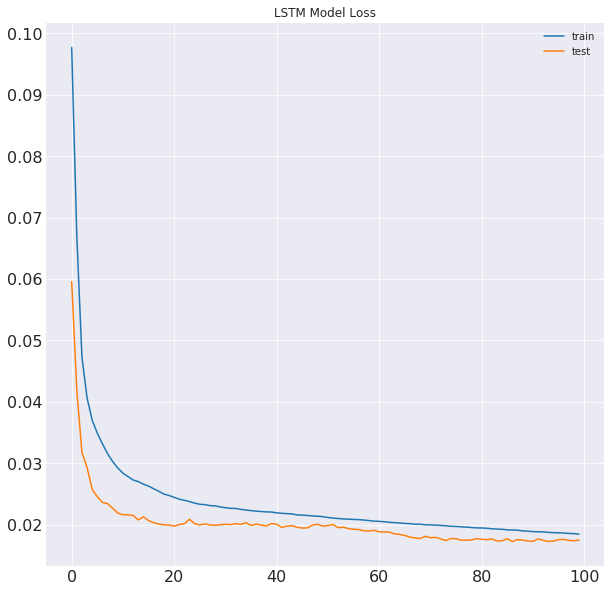

In [14]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [15]:
# make a prediction 
yhat = model.predict(test_X)
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

# invert scaling for forecast# invert 
inv_yhat = np.concatenate((test[:, 55:59], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 55:59], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
print("mean absolute error percentage: ", maep)

R2:   0.961164113810352
MAE:  981.61475
RMSE: 1296.494263388774
mean absolute error percentage:  11.347759515047073


Time sequence 48hours(from 47 hours get 1 hours)

In [16]:
features_and_target = pd.concat([data, num_pickups], axis = 1)
values = features_and_target.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

n_hours = 47

reframed = series_to_supervised(scaled, n_hours, 1)

n_features = features_and_target.shape[1]


In [17]:
# delete significantly wrong data
total_values = reframed.values
n_p = np.argmin(total_values[365*24*3:, -1])
n_p = n_p + 365*24*3

a = total_values[: n_p, :]
b = total_values[n_p + n_hours + 1 : , :]
values = np.concatenate((a, b), axis=0)

In [18]:
# split into train and test sets# split i # split  
n_train_hours = 365 * 24 * 3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 235) 26280 (26280,)
(26280, 47, 5) (26280,) (6469, 47, 5) (6469,)


In [ ]:
# design network
model = Sequential()
model.add(LSTM(48, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 26280 samples, validate on 6469 samples
Epoch 1/100
 - 14s - loss: 0.0962 - val_loss: 0.0475
Epoch 2/100
 - 14s - loss: 0.0540 - val_loss: 0.0319
Epoch 3/100
 - 14s - loss: 0.0404 - val_loss: 0.0261
Epoch 4/100
 - 14s - loss: 0.0356 - val_loss: 0.0247
Epoch 5/100
 - 14s - loss: 0.0335 - val_loss: 0.0261
Epoch 6/100
 - 14s - loss: 0.0303 - val_loss: 0.0223
Epoch 7/100
 - 14s - loss: 0.0283 - val_loss: 0.0234
Epoch 8/100
 - 13s - loss: 0.0271 - val_loss: 0.0226
Epoch 9/100
 - 14s - loss: 0.0258 - val_loss: 0.0204
Epoch 10/100
 - 14s - loss: 0.0251 - val_loss: 0.0198
Epoch 11/100
 - 14s - loss: 0.0245 - val_loss: 0.0191
Epoch 12/100
 - 14s - loss: 0.0239 - val_loss: 0.0191
Epoch 13/100
 - 14s - loss: 0.0219 - val_loss: 0.0176
Epoch 14/100
 - 14s - loss: 0.0210 - val_loss: 0.0179
Epoch 15/100
 - 13s - loss: 0.0202 - val_loss: 0.0171
Epoch 16/100
 - 14s - loss: 0.0197 - val_loss: 0.0174
Epoch 17/100
 - 14s - loss: 0.0192 - val_loss: 0.0180
Epoch 18/100
 - 14s - loss: 0.0187 - val_l

In [ ]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [ ]:
# make a prediction 
yhat = model.predict(test_X)
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

# invert scaling for forecast# invert 
inv_yhat = np.concatenate((test[:, 235:239], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 235:239], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
print("mean absolute error percentage: ", maep)